In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from gensim.models import Word2Vec
from scapy.all import PcapReader
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from read_pcaps import pcap_to_dataframe

2024-02-02 10:45:38.805301: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 10:45:38.871534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 10:45:38.871594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 10:45:38.873825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 10:45:38.884565: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 10:45:40.618545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [2]:
# define a variable that allows you to read prior saved pkl files
READ_FROM_PKL = True

In [3]:
if READ_FROM_PKL:
    mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
    benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")
else:
    pcap_reader_mirai = PcapReader("../data/blog_eda/mirai.pcap")
    pcap_reader_benign = PcapReader("../data/blog_eda/benign.pcapng")
    mirai_df = pcap_to_dataframe(pcap_reader_mirai)
    benign_df = pcap_to_dataframe(pcap_reader_benign)

In [4]:
# read features saved, add new ones
if READ_FROM_PKL:
    mirai_features_df = pd.read_pickle("../data/blog_fe/mirai_features.pkl")
    benign_features_df = pd.read_pickle("../data/blog_fe/benign_features.pkl")
else:
    print(
        "Error! Feature pkl not saved. Please run blog_fe_2.ipynb, blog_fe_3.ipynb or download from here: https://drive.google.com/drive/folders/1dBQhbQtIk_fbbb80G5pSVV3hbWYJY7fv?usp=sharing"
    )

In [5]:
# drop rows with None
mirai_df = mirai_df.dropna()
benign_df = benign_df.dropna()

# Payload Embeddings

## Tokenize

In [6]:
# Tokenize the payload column to individual words
mirai_tokenized_payloads = benign_df["Payload"].apply(lambda x: x.lower().split())

mirai_tokenized_payloads

4           [raw]
5           [raw]
6           [raw]
7           [raw]
26          [raw]
           ...   
38585    [radius]
38586    [radius]
38587    [radius]
38588    [radius]
38589    [radius]
Name: Payload, Length: 18615, dtype: object

In [7]:
# Tokenize the payload column to individual words
benign_tokenized_payloads = benign_df["Payload"].apply(lambda x: x.lower().split())

benign_tokenized_payloads

4           [raw]
5           [raw]
6           [raw]
7           [raw]
26          [raw]
           ...   
38585    [radius]
38586    [radius]
38587    [radius]
38588    [radius]
38589    [radius]
Name: Payload, Length: 18615, dtype: object

## word2vec

In [8]:
# Train Word2Vec model on tokenized payloads
mirai_word2vec_model = Word2Vec(
    sentences=mirai_tokenized_payloads,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
)

In [9]:
# Train Word2Vec model on tokenized payloads
benign_word2vec_model = Word2Vec(
    sentences=benign_tokenized_payloads,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
)

In [10]:
# Function to calculate the average word embedding for a sentence
def average_word_embedding(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    # fix size of embeddings if it is variable
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [11]:
# Apply the average_word_embedding function to create a new column 'payload_embedding'
mirai_features_df["payload_embedding"] = mirai_tokenized_payloads.apply(
    lambda x: average_word_embedding(x, mirai_word2vec_model)
)

# Display the resulting DataFrame
mirai_features_df

/tmp/ipykernel_525070/71745738.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mirai_features_df["payload_embedding"] = mirai_tokenized_payloads.apply(


,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio,cumulative_length,...,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy,payload_embedding
0,1.540446e+09,21074.0,80.0,Padding,26.0,6.0,0.0,51747.0,0.000000,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.540446e+09,20532.0,8280.0,Padding,26.0,6.0,0.0,51747.0,0.000000,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1.540446e+09,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83.0,17.0,4257.0,714.0,5.962185,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.540446e+09,53.0,2440.0,DNS Ans,83.0,17.0,27647.0,400.0,69.117500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.540446e+09,21074.0,80.0,Padding,26.0,6.0,0.0,51747.0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.022534447, 0.0001851973, 0.083829634, -0.01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
764122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
764124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
764125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
# Apply the average_word_embedding function to create a new column 'payload_embedding'
benign_features_df["payload_embedding"] = benign_tokenized_payloads.apply(
    lambda x: average_word_embedding(x, benign_word2vec_model)
)

# Display the resulting DataFrame
benign_features_df

/tmp/ipykernel_525070/544991880.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  benign_features_df["payload_embedding"] = benign_tokenized_payloads.apply(


,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,incoming_traffic,outgoing_traffic,traffic_ratio,cumulative_length,...,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy,payload_embedding
0,1.355254e+09,646.0,646.0,Raw,42.0,17.0,0.0,144.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.355254e+09,646.0,646.0,Raw,42.0,17.0,0.0,144.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.355254e+09,646.0,646.0,Raw,42.0,17.0,0.0,146.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.355254e+09,646.0,646.0,Raw,42.0,17.0,0.0,146.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.355254e+09,646.0,646.0,Raw,42.0,17.0,0.0,146.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.022539267, 0.00016932, 0.08378327, -0.01717..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.004800662, -0.0036283778, -0.00426481, 0.00..."
38586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.004800662, -0.0036283778, -0.00426481, 0.00..."
38587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.004800662, -0.0036283778, -0.00426481, 0.00..."
38588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.004800662, -0.0036283778, -0.00426481, 0.00..."


In [13]:
# eliminate payload and keep only numerical features
mirai_features_df.pop("Payload")
benign_features_df.pop("Payload")

0        Raw
1        Raw
2        Raw
3        Raw
4        Raw
        ... 
38585    NaN
38586    NaN
38587    NaN
38588    NaN
38589    NaN
Name: Payload, Length: 27291, dtype: object

## Tensorflow

In [14]:
# Load the Universal Sentence Encoder
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_embed = hub.load(use_url)


# Function to generate embeddings for payloads
def generate_embeddings(payloads):
    embeddings = use_embed(payloads).numpy()
    return embeddings

2024-02-02 10:45:52.157595: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
# Generate embeddings for the "payload" column for a subset of mirai because it takes tooooooo looooong
mirai_df_subset = mirai_df.head(1000)
mirai_df_subset["payload_embedding_tensorflow"] = mirai_df_subset["Payload"].apply(
    lambda x: generate_embeddings([x])
)

mirai_df_subset

/tmp/ipykernel_525070/302763812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirai_df_subset["payload_embedding_tensorflow"] = mirai_df_subset["Payload"].apply(


,Timestamp,Source IP,Destination IP,Source Port,Destination Port,Payload,Packet Length,Protocol,payload_embedding_tensorflow
0,1540446382.933899,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,"[[-0.07675511, 0.057904616, -0.009692829, 0.06..."
1,1540446382.933904,192.168.2.108,52.25.66.250,20532.0,8280.0,Padding,26,6.0,"[[-0.07675511, 0.057904616, -0.009692829, 0.06..."
7,1540446383.391651,192.168.2.115,192.168.2.1,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,"[[0.039899036, 0.008909398, -0.05074613, 0.010..."
8,1540446383.393709,192.168.2.1,192.168.2.115,53.0,2440.0,DNS Ans,83,17.0,"[[-0.00027457796, -0.021816308, -0.060570717, ..."
9,1540446383.435821,192.168.2.108,52.24.43.67,21074.0,80.0,Padding,26,6.0,"[[-0.07675511, 0.057904616, -0.009692829, 0.06..."
...,...,...,...,...,...,...,...,...,...
1451,1540446434.180041,192.168.2.113,61.188.37.216,50861.0,10240.0,Raw,48,17.0,"[[-0.034268547, -0.0059591196, 0.05479314, 0.0..."
1452,1540446434.180043,192.168.2.113,120.24.59.150,50861.0,10240.0,Raw,48,17.0,"[[-0.034268547, -0.0059591196, 0.05479314, 0.0..."
1454,1540446434.182208,192.168.2.113,114.215.137.159,50861.0,10240.0,Raw,48,17.0,"[[-0.034268547, -0.0059591196, 0.05479314, 0.0..."
1455,1540446434.182979,192.168.2.113,104.199.156.58,50861.0,10240.0,Raw,48,17.0,"[[-0.034268547, -0.0059591196, 0.05479314, 0.0..."


## Similarity

### word2vec

In [16]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Example sentences to train Word2Vec model (you can use a larger corpus for better results)
cybersecurity_words = [
    "firewall",
    "malware",
    "phishing",
    "encryption",
    "authentication",
    "vulnerability",
    "patch",
    "incident",
    "antivirus",
    "cryptography",
    "update",
    "spyware",
    "verification",
]

sentences = [cybersecurity_words]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=3, window=5, min_count=1, workers=4)

# Get Word2Vec embeddings
word_embeddings = {word: model.wv[word] for word in cybersecurity_words}

In [17]:
# Function to calculate cosine similarity between embeddings
def calculate_cosine_similarity(embeddings, dictionary):
    if dictionary:
        similarities = {}
    else:
        similarities = np.zeros((len(embeddings), len(embeddings)))
    for i, word1 in enumerate(embeddings):
        for j, word2 in enumerate(embeddings):
            if dictionary:
                if word1 != word2:
                    similarity = cosine_similarity(
                        [embeddings[word1]], [embeddings[word2]]
                    )[0][0]
                    similarities[(word1, word2)] = similarity
            else:
                if i != j:
                    similarity = cosine_similarity(
                        [embeddings[word1]], [embeddings[word2]]
                    )[0][0]
                    similarities[i, j] = similarity
    return similarities

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarities
similarities = calculate_cosine_similarity(word_embeddings, 1)

# Print the cosine similarities
for pair, similarity in similarities.items():
    print(f"Cosine Similarity between '{pair[0]}' and '{pair[1]}': {similarity:.4f}")

Cosine Similarity between 'firewall' and 'malware': -0.5714
Cosine Similarity between 'firewall' and 'phishing': -0.4492
Cosine Similarity between 'firewall' and 'encryption': 0.8851
Cosine Similarity between 'firewall' and 'authentication': 0.9811
Cosine Similarity between 'firewall' and 'vulnerability': 0.0108
Cosine Similarity between 'firewall' and 'patch': -0.0726
Cosine Similarity between 'firewall' and 'incident': -0.8923
Cosine Similarity between 'firewall' and 'antivirus': -0.8096
Cosine Similarity between 'firewall' and 'cryptography': -0.8792
Cosine Similarity between 'firewall' and 'update': -0.0103
Cosine Similarity between 'firewall' and 'spyware': 0.8620
Cosine Similarity between 'firewall' and 'verification': -0.1071
Cosine Similarity between 'malware' and 'firewall': -0.5714
Cosine Similarity between 'malware' and 'phishing': 0.4009
Cosine Similarity between 'malware' and 'encryption': -0.2096
Cosine Similarity between 'malware' and 'authentication': -0.6374
Cosine Sim

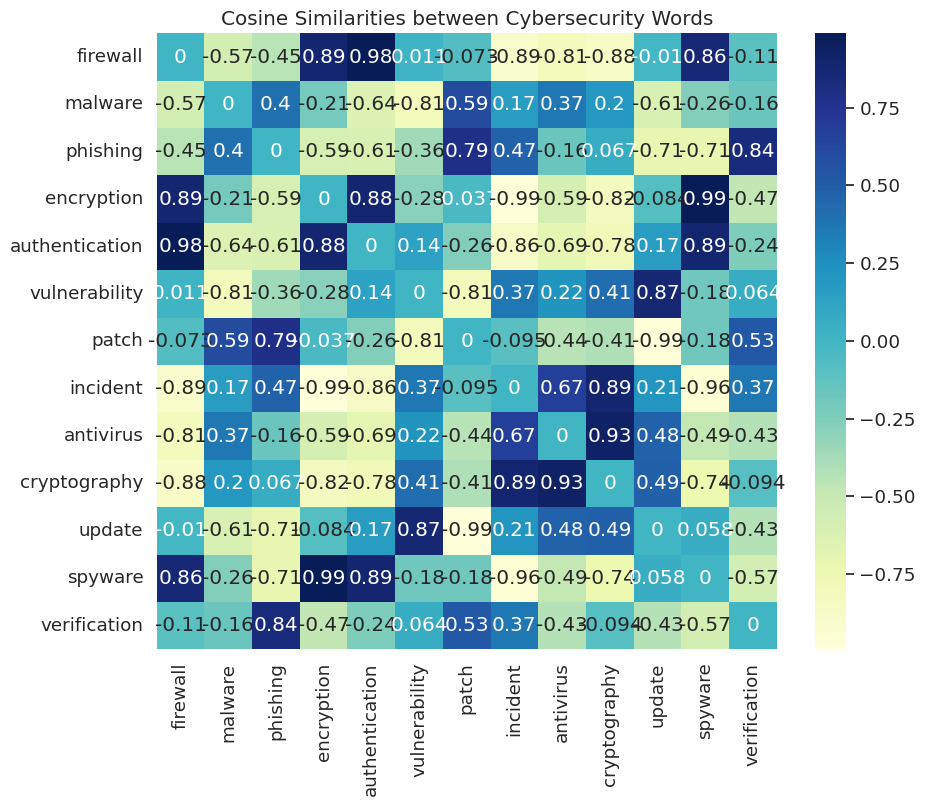

In [19]:
# Calculate cosine similarities arrays for plotting
similarities = calculate_cosine_similarity(word_embeddings, 0)

# Plot the heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(
    similarities,
    annot=True,
    xticklabels=cybersecurity_words,
    yticklabels=cybersecurity_words,
    cmap="YlGnBu",
)
plt.title("Cosine Similarities between Cybersecurity Words")
plt.show()

### spacy

In [20]:
nlp = spacy.load("en_core_web_md")


# Function to get the word embeddings
def get_word_embeddings(word_list):
    embeddings = {}
    for word in word_list:
        embeddings[word] = nlp(word).vector
    return embeddings


# Get word embeddings for the cybersecurity words
word_embeddings = get_word_embeddings(cybersecurity_words)

# Print the word embeddings
for word, embedding in word_embeddings.items():
    print(f"{word}: {embedding}")

firewall: [-1.6523e+00  5.5110e+00  8.1038e-01 -7.9729e-01  1.3327e+00  2.4186e+00
  1.3893e-01  2.2258e+00 -5.0718e+00  1.8634e+00  7.2355e+00  3.1384e+00
 -5.7215e+00  6.0735e+00 -4.3423e-02 -2.9377e+00  1.4363e+00  2.4079e+00
  2.7791e-01 -2.4794e+00  2.5056e+00  8.9530e-01  3.0210e-01 -9.8915e-01
 -2.7558e+00 -2.5174e+00 -9.3562e+00 -7.0564e+00 -6.1858e-01  1.6196e+00
 -7.9593e-01  5.8761e-01 -1.7660e+00 -4.7503e-01  1.9022e+00  1.6578e+00
 -1.2463e+00 -1.4468e+00  1.5198e+00  3.1851e+00  5.0258e+00 -4.1007e+00
 -2.6974e-01  1.7610e+00  6.3950e-01 -1.0230e+00  1.9629e+00  6.2564e-01
  1.1285e+00 -4.7231e+00 -2.3986e-01  1.1325e+00 -8.6009e-01 -1.7104e+00
 -1.9912e+00 -1.7239e+00  2.1164e+00  4.4801e+00 -8.8042e-01 -1.2654e+00
  2.1019e+00  2.8206e+00 -4.0967e+00 -5.1590e+00  3.0628e-01  2.5849e+00
 -6.0512e+00 -5.6095e-01 -2.1507e+00  2.4525e+00 -1.8071e+00  1.6670e+00
 -1.8418e+00  3.0830e+00  2.5615e+00  4.8218e-02 -2.9378e-01 -2.1008e+00
 -4.3634e+00 -5.0285e+00  9.6513e-01 -4.0

In [21]:
# Get word embeddings for the cybersecurity words
word_embeddings = {word: nlp(word).vector for word in cybersecurity_words}

# Calculate cosine similarities
similarities = calculate_cosine_similarity(word_embeddings, 1)

# Print the cosine similarities
for pair, similarity in similarities.items():
    print(f"Cosine Similarity between '{pair[0]}' and '{pair[1]}': {similarity:.4f}")

Cosine Similarity between 'firewall' and 'malware': 0.4331
Cosine Similarity between 'firewall' and 'phishing': 0.3735
Cosine Similarity between 'firewall' and 'encryption': 0.5533
Cosine Similarity between 'firewall' and 'authentication': 0.4876
Cosine Similarity between 'firewall' and 'vulnerability': 0.3675
Cosine Similarity between 'firewall' and 'patch': 0.4452
Cosine Similarity between 'firewall' and 'incident': 0.1459
Cosine Similarity between 'firewall' and 'antivirus': 0.4331
Cosine Similarity between 'firewall' and 'cryptography': 0.5533
Cosine Similarity between 'firewall' and 'update': 0.3660
Cosine Similarity between 'firewall' and 'spyware': 0.4331
Cosine Similarity between 'firewall' and 'verification': 0.3712
Cosine Similarity between 'malware' and 'firewall': 0.4331
Cosine Similarity between 'malware' and 'phishing': 0.6212
Cosine Similarity between 'malware' and 'encryption': 0.6186
Cosine Similarity between 'malware' and 'authentication': 0.4620
Cosine Similarity bet

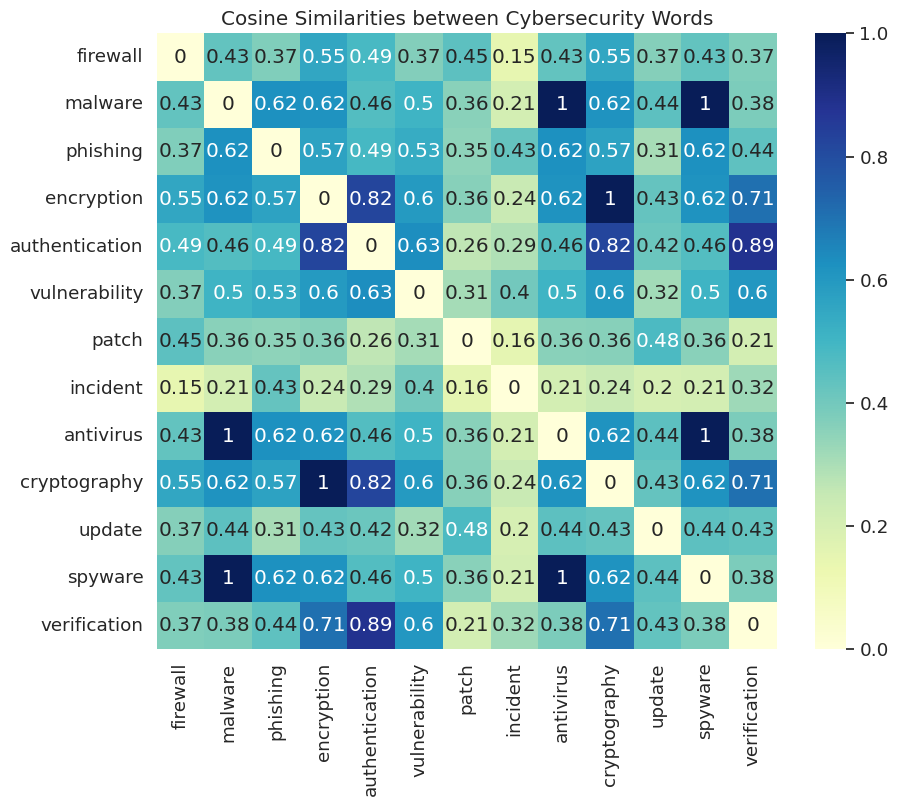

In [22]:
# Calculate cosine similarities arrays for plotting
similarities = calculate_cosine_similarity(word_embeddings, 0)

# Plot the heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 8))
sns.heatmap(
    similarities,
    annot=True,
    xticklabels=cybersecurity_words,
    yticklabels=cybersecurity_words,
    cmap="YlGnBu",
)
plt.title("Cosine Similarities between Cybersecurity Words")
plt.show()

# Neural nets example

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Generate some dummy data for demonstration purposes
# In a real-world scenario, you would use a dataset containing features extracted from network traffic.
np.random.seed(42)
num_samples = 1000
features = np.random.rand(num_samples, 10)  # 10 features for each sample
labels = np.random.choice(["malicious", "benign"], size=num_samples)

# Encode labels into numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, encoded_labels, test_size=0.2, random_state=42
)

# Build a simple neural network model using TensorFlow and Keras
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(10,)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).flatten()
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Epoch 1/10
25/25 [==============================] - 1s 13ms/step - loss: 0.6973 - accuracy: 0.4675 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6873 - val_accuracy: 0.5550
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5125 - val_loss: 0.6870 - val_accuracy: 0.5350
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5475 - val_loss: 0.6872 - val_accuracy: 0.5250
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5425 - val_loss: 0.6853 - val_accuracy: 0.5450
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5487 - val_loss: 0.6848 - val_accuracy: 0.5450
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5738 - val_loss: 0.6873 - val_accuracy: 0.5350
Epoch 8/10
25/25 [=

# Save features dataframe

In [24]:
# save new features
mirai_features_df.to_pickle("../data/blog_fe/mirai_features.pkl")
benign_features_df.to_pickle("../data/blog_fe/benign_features.pkl")